# MSc thesis part 1: main script

### Several functions have been defined and are saved in separate files
### Author: Pim Arendsen

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random
import pickle
import collections
import nbimporter
import cv2
import torch.nn.functional as F
import math

from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, transforms, models
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook
from sklearn import linear_model
from sklearn import metrics
from statistics import mean


#import functions from other files
from p1_CreateTrainingDataframe import CreateTrainingDataframe
from p1_CreateTestDataframe import CreateTestDataframe
from p1_BrodenDataSet import BrodenDataset
from p1_RescaleImage import Rescale
from p1_TransformToTensor import ToTensor
from p1_GetVectorFromImage import GetVector
from p1_GetCosineSimilarityDistance import GetCosineSimilarityDistance
from p1_MakeVectorDictionary import MakeVectorDictionary
from p1_SubsetConceptImages import SubsetConceptImages
from p1_GetCAV import GetCav

Importing Jupyter notebook from p1_CreateTrainingDataframe.ipynb
Importing Jupyter notebook from p1_CreateTestDataframe.ipynb
Importing Jupyter notebook from p1_BrodenDataSet.ipynb
Importing Jupyter notebook from p1_RescaleImage.ipynb
Importing Jupyter notebook from p1_TransformToTensor.ipynb
Importing Jupyter notebook from p1_GetVectorFromImage.ipynb
Importing Jupyter notebook from p1_GetCosineSimilarityDistance.ipynb
Importing Jupyter notebook from p1_MakeVectorDictionary.ipynb
Importing Jupyter notebook from p1_SubsetConceptImages.ipynb
Importing Jupyter notebook from p1_GetCAV.ipynb


Set the seed to ensure similar randomness

## Part 1.1: Download a pretrained ResNet50 and edit the last layers

Download a pretrained model and define the layer from which to extract the image vectors

In [2]:
basenet = models.resnet50(pretrained=True)
out_layer = basenet._modules.get('avgpool')

## Part 1.2: Define the concepts in the Broden dataset

Define directories of the different folders. 
Set the working directory and change the directories accordingly

In [3]:
broden_dataset_path = '../data/broden1_384/'
index_file_path = os.path.join(broden_dataset_path, 'index.csv')
label_file_path = os.path.join(broden_dataset_path, 'label.csv')

Create training dataset by parsing through the Broden dataset. The data is already split in 70% train and 30% test data

In [4]:
REBUILD_DATA = False #set a manual flag to prevent rebuilding the data once it is available

In [5]:
if REBUILD_DATA:
    
    # create the training data dataframe
    print('creating training dataset')
    training_data = CreateTrainingDataframe(index_file_path, label_file_path, broden_dataset_path)
    print('writing training data...')    
    training_data.to_csv('../data/training_data.csv', index=False)
    
    # create the testdata dataframe
    test_data = CreateTestDataframe(index_file_path, label_file_path, broden_dataset_path)
    print('writing test data...')
    test_data.to_csv('../data/test_data.csv', index=False)
    print('Done')


If the training and test data is already available: update the following directories

In [6]:
training_data_path = '../data/training_data.csv'
test_data_path = '../data/test_data.csv'

## Part 1.3 Determine CAVs using the Broden dataset


The Broden dataset is converted into a PyTorch Dataset class, which can be used to access indivual images. <br>
The images are rescaled to 224x224 pixels, transformed to tensors and normalized according to the PyTorch documentation. <br>

The dataset returns a dictionary with the following keys: 
- 'image': as ndarray or tensor, depending on the transformation
- 'concept': a list of all the concepts within an image
- 'concept_vector': a one-hot array for each concept in the image

In [7]:
train_broden_dataset = BrodenDataset(csv_file = training_data_path, 
                               data_path = broden_dataset_path, 
                               transform = transforms.Compose([Rescale(224),
                                                              ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    std=[0.229, 0.224, 0.225])
                                                              ]))

In [8]:
test_broden_dataset = BrodenDataset(csv_file = test_data_path,
                                    data_path = broden_dataset_path, 
                                    transform = transforms.Compose([Rescale(224),
                                                                    ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                         std=[0.229, 0.224, 0.225])
                                                                   ]))

Next, a concept activation vector will be determined for 6 concept. This will be expanded further on in the project to multiple concepts. This requires several steps:
- get images for a specific concept
- get random images which do not contain the concept
- train a linear classifier between the concept and the random counter examples
- determine the vector orthogonal to the linear classifier in the direction of the concept, this is the CAV

**Questions to answers:**
- How to cope with the imbalanced dataset? Will this influence the concepts or the counter examples?
- What about miss classification of concepts in images?
- How many images (concept images as well as counter examples) are needed to get an accurate CAV?
- Do the amount of images need to be equal?

Read the training data into a dataframe

In [9]:
training_data = pd.read_csv(training_data_path, sep=',')

### Get images for a specific concept

Define a concept

In [ ]:
concept = 'mountain'
file_name = concept + '_vectors.pickle'

Determine the row index values of the concept in the training dataframe

In [ ]:
idxs = training_data.loc[training_data[concept] == 1, 'image'].index.tolist()

In [ ]:
print('The concept "%s" is present in %d images' % (concept, len(idxs)))

The first *n* images labelled with the above defined concept can be viewed

In [ ]:
SHOW_IMG = False # set a manual flag to show images, this is done to run the entire script without have to load the images
n = 10 

In [ ]:
if SHOW_IMG:
    
    for i in range(n):
        print('row index', idxs[i])
        plt.figure()
        plt.imshow(io.imread(os.path.join(broden_dataset_path, 'images/', training_data.loc[idxs[i], 'image'])))
        plt.show()
        print('--------------')

As can be seen by viewing some images, the labelled images are noisy, not all images contain the defined concept. As such, the images need to be filtered. This is done by applying the following steps:

1. Push all images through the CNN and store the output tensors
2. Manually, select 5 images from the Broden dataset which do contain the defined concept, referred to as *reference images*
3. For each of these reference images: <br>
    a. calculate the cosine similarity of the *reference tensor* to all other tensors <br>
    b. select the tensors which fall within the similarity threshold 
4. The tensors which fall within the similarity threshold in multiple reference images contain the concept
5. Link the selected tensors back to the image

This will be explained in further detail below

The method cannot be used to get the CAV of a concept, it should contain more randomness as the manual selection of images introduces bias. However, this methods can be used to show that the ResNet50 model captures semantical information. Which confirms the main assumption that images showing the same concept, result in similar tensors when run through the network. Or in other words, the models captures semantically similar images

-----------------------------------------------

The images from the Broden Dataset which are labelled with the defined concept are run through the model and are stored in a dictionary. The dictionary contains the following keys and values:
- keys (string): row index of image in the training dataframe
- value (torch.tensor): the vector from the *out_layer* after the image is passed through the network

In [ ]:
MAKE_DICT = False # set a manual flag to prevent recreating the tensor dictionary if it already exists

In [ ]:
if MAKE_DICT:
    vector_dict = MakeVectorDictionary(basenet, out_layer, train_broden_dataset, idxs, file_name)
else:
    with open(os.path.join('../data/', file_name), 'rb') as handle:
        vector_dict = pickle.load(handle)

For six concepts, 5 reference images have been manually defined. *This does cause confirmation bias. How can 5 images capture a concept? E.g. what exactly is a mountain? Where lies the difference between a mountain and a hill?*

In [ ]:
img_reference_dict = {'mountain': ['6636', '33439', '30055', '21198', '33075'],
                     'highway-s': ['3617', '2836', '407', '1013', '1594'],
                     'river': ['1052', '2103', '3906', '4783', '1669'],
                     'forest-broadleaf-s': ['2681', '4622', '6639', '15993', '12546'],
                     'building': ['65', '109', '157', '61', '136'],
                     'truck': ['95', '4166', '5886', '6270', '6874']}

For one of the concepts, the tensor of each of the reference images is used to calculate the cosine similarity with all other tensors. The cosine similarity calculates the angle between tensors in the feature space. Tensors which contain the concept should be similar to the reference tensor and thus have a small angle. The cosine similarity ranges from 1 to -1, where a value of 1 exactly matches the reference tensor and -1 goes in the opposite direction. This is where the *similarity threshold* is introduced. It determines how similar a tensor must be to the reference tensor. Tensors ranging from the similarity threshold - 1 are assumed to contain the concept and are stored. This is done for each of the reference tensors. If tensors fall within the similarity threshold multiple times (for different reference tensors), they are also stored multiple times.<br> 

This is where an other *overlap threshold* is introduced. As tensors can be within the cosine similarity threshold multiple times, the *overlap threshold* determines how many times the tensor must be stored. If the overlap is set to 5, only tensors which fall within the similarity threshold for each of the 5 reference images are selected. <br>

The tensors which fall within both thresholds are linked back to the image indices.
 

In [ ]:
similarity_threshold = 0.75
overlap_threshold = [4,5] 

concept_imgs = SubsetConceptImages(img_reference_dict, concept, vector_dict, similarity_threshold, overlap_threshold)
print('Amount of filtered images with concept %s: %d' % (concept, len(concept_imgs)))

In [ ]:
for i in range(10):
    plt.figure()
    plt.imshow(io.imread(os.path.join(broden_dataset_path, 'images/', training_data.loc[int(concept_imgs[i]), 'image'])))
    plt.show()

### Get random counter examples

Make a list of row indices which do not contain the defined concept

In [ ]:
non_concept = [i for i in range(len(training_data)) if i not in idxs]
random_img_file = 'random_imgs_vectors.pickle'

Sample *m* random images 

In [ ]:
m = 200
counter_img = random.sample(non_concept, m)

Create a dictionary which stores the vectors of the random chosen images

In [ ]:
MAKE_RANDOM_DICT = False

In [ ]:
if MAKE_RANDOM_DICT:
    random_img_dict = MakeVectorDictionary(basenet, 
                                           out_layer, 
                                           train_broden_dataset, 
                                           counter_img, 
                                           random_img_file)
else:
    with open(os.path.join('../data/', random_img_file), 'rb') as handle:
        random_img_dict = pickle.load(handle)

---

### Train a linear classifier between the concept images and the random images

To experiment with CAVs the 'scene' concepts are used, as these images are better classified then other concepts. The following scene concepts have been used to experiment with the different option to get a CAV.

In [10]:
test_data = pd.read_csv('../data/test_data.csv')

In [ ]:

scene_concepts =['street-s', 'mountain_snowy-s', 'highway-s', 'skyscraper-s',  'park-s', 'mountain-s', 'coast-s',
                'beach-s', 'field-cultivated-s', 'valley-s', 'bus_shelter-s', 'hayfield-s', 'hill-s', 'building_facade-s', 
                'pasture-s']

First, the amount of images representing a concept needs to be chosen. Some concepts have many images describing the concept. However, concepts like *bus shelter* only have 10 images to train a CAV on. These different amounts of images will be used to check how many images are required to train a accurate CAV.<br>
For most concepts the ratio is *50 concept images : 100 random images*

In [ ]:
random.seed(123)
concept = 'street-s'

#concept images
n = 50

#random images
m = 200

1. The CAV is calculated by randomly selected the indicated amount of concept images and random images. The images used are returned, just as the CAV and the linear classification model. This is used to check the accuracy <br>

2. To test the accuracy of the model and thus the CAV, test images are used to check the prediction. To do this, for every *scene* concept, 50 random labelled test images are selected. If there are not sufficient test images, the total amount of test images is taken. All indices are merged into the same list, and they are added to a dictionary with the concept as key and the matching image indices as values
3. The selected test images are run through the ResNet50 model and the tensors are stored

In [ ]:
accuracy_list = []

for ii in range(20):
    for n in range(10, 200, 10):

        # 1. Train the CAV and the linear classification model
        concept_idxs, counter_idxs, cav, model = GetCav(concept, n, m, training_data, basenet, out_layer, train_broden_dataset)


        # 2. Indices of test data are stored
        random.seed(123)
        test_scene_dict = {}
        test_scene_idxs =[]
        for scene in scene_concepts:
            scene_idx = test_data.loc[test_data[scene] == 1, 'image'].index.tolist()
            if len(scene_idx) > 50:
                scene_idx = random.sample(scene_idx, 50)

            test_scene_dict[scene] = scene_idx

            list(map(lambda x: test_scene_idxs.append(x), scene_idx))


        # 3. Tensors for each image is extracted
        test_filename = 'test_scene_vector.pickle'

        test_scene_vector_dict = {}

        if not os.path.exists(os.path.join('../data/', test_filename)):
            for key in scene_concepts:
                print(key)

                # get all indices for the concept
                temp_scene_idxs = test_scene_dict[key]

                #for every scene, store the index value of the image as key and the tensor as value
                temp_dict = MakeVectorDictionary(basenet, out_layer, test_broden_dataset, temp_scene_idxs, None)
                temp_keys = list(temp_dict.keys())
                test_scene_vector_dict[key] = temp_dict[temp_keys[0]].unsqueeze(0)

                for i in range(1, len(temp_dict.keys())):
                    #for every key (index value of image belonging to the concept), get the tensor and add it to the vector dictionary
                    test_scene_vector_dict[key] = torch.cat((test_scene_vector_dict[key], temp_dict[temp_keys[i]].unsqueeze(0)))

            with open(os.path.join('../data/', test_filename), 'wb') as handle:
                    pickle.dump(test_scene_vector_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        else:
            with open(os.path.join('../data/', test_filename), 'rb') as handle:
                test_scene_vector_dict = pickle.load(handle)


        # 4. Preprocess test data       
        start_idx = 0
        for key in scene_concepts:
            if key == concept:
                break
            else:
                start_idx += len(test_scene_vector_dict[key])

        end_idx = start_idx + len(test_scene_vector_dict[concept])+1

        #create the right labels on the right tensors
        y_test = np.zeros(len(test_scene_idxs))
        y_test[start_idx:end_idx] = 1

        #create test matrix
        X_test = test_scene_vector_dict[scene_concepts[0]]
        for i in range(1, len(scene_concepts)):
            temp_vector = test_scene_vector_dict[scene_concepts[i]]
            X_test = torch.cat((X_test, temp_vector),0)

        X_test = X_test.numpy()

        # 5. Use the model to classify the test data
        y_pred = model.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        acc = [n, m, [accuracy]]
    
        if ii > 0:
            for sublist in accuracy_list:
                if sublist[1] == n:  ####################### CHANGE THIS TO 'm' or 'n'
                    sublist[2].append(accuracy)
        else:
            accuracy_list.append(acc)    
    
# 6. Plot accuracy with different parameters
ns = []
ms = []
ys = []
for sublist in accuracy_list:
    ns.append(sublist[0])
    ms.append(sublist[1])
    ys.append(mean(sublist[2]))

plt.plot(ns, ys)
plt.ylim(0.4,1)
plt.title(concept + '; counter examples: '+ str(m))
plt.xlabel('amount of concept images')
plt.ylabel('accuracy')
plt.show()

In [ ]:
mountain_snowy = accuracy_list.copy()

Show concept images

In [ ]:
%matplotlib inline
dim = math.floor(math.sqrt(len(concept_idxs)))

fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

for idx, a in enumerate(ax):
    img = plt.imread(os.path.join(broden_dataset_path, 'images/', training_data.loc[concept_idxs[idx], 'image']))
    a.axis('off')
    a.imshow(img)
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Show random counter images

In [ ]:
%matplotlib inline
dim = math.floor(math.sqrt(len(counter_idxs)))

fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

for idx, a in enumerate(ax):
    img = plt.imread(os.path.join(broden_dataset_path, 'images/', training_data.loc[counter_idxs[idx], 'image']))
    a.axis('off')
    a.imshow(img)
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

---

# TorchCAV class

In [100]:
class TorchCAV(object):
    
    def __init__(self, concept, num_concept_imgs, num_counter_imgs,
                 n_network, output_layer, training_torch_dataset, test_torch_dataset, 
                 training_dataframe, test_dataframe, training_mode = True):

        self.concept = concept
        self.num_concept_imgs = num_concept_imgs
        self.num_counter_imgs = num_counter_imgs
        self.n_network = n_network
        self.output_layer = output_layer
        self.training_torch_dataset = training_torch_dataset
        self.test_torch_dataset = test_torch_dataset
        self.training_dataframe = training_dataframe
        self.test_dataframe = test_dataframe
        self.training_mode = training_mode
        
        
        self.concept_idxs = []
        self.concept_dictionary = {}
        self.random_concept_idxs = []
        self.random_counter_idxs = []
        self.counter_dictionary = {}
        self.counter_dictionary_name = concept + '_' + str(num_counter_imgs) + '_counter_imgs.pickle'
        
        self.lm = None
        self.cav = None
        
        if self.training_mode:
            self.dictionary_name = concept + '_training_vectors.pickle'
        else:
            self.dictionary_name = concept + '_test_vectors.pickle'

        if self.concept not in list(self.training_dataframe):
            raise ValueError ('%s is not present in the dataset' % self.concept)

        random.seed(42)    
        
    def get_concept_indices(self):
        if self.training_mode:
            self.concept_idxs = self.training_dataframe.loc[self.training_dataframe[self.concept] == 1, 'image'].index.tolist()
        else:
            self.concept_idxs = self.test_dataframe.loc[self.test_dataframe[self.concept] == 1, 'image'].index.tolist()

        return self.concept_idxs

    def get_image_tensor(self, img_tensor):
        """
        The function extracts the feature vector of an image from the 'avgpool' layer in a model

        Args:
            img_tensor (torch.Tensor): a tensor of an image
            self.n_network (torchvision.model): a Neural Network or Convolutional NN
            self.out_layer: a layer of the nn, from which the output will be extracted

        Returns:
            torch.Tensor: the vector of the image in the out_layer
        """

        #Create a PyTorch Variable with the transformed image
        img = Variable(img_tensor).unsqueeze(0)

        # Create a vector of zeros that will hold the feature vector of the image. 
        # The 'avgpool' layer of the ResNet50 has an output size of 2048
        my_embedding = torch.zeros(2048)

        # Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            my_embedding.copy_(o.data.squeeze())

        # Attach that function to our selected layer
        h = self.output_layer.register_forward_hook(copy_data)

        # Run the model on our transformed image
        self.n_network(img)

        # Detach our copy function from the layer
        h.remove()

        # Return the feature vector
        return my_embedding
    
    def make_index_tensor_dictionary(self, dictionary, dictionary_name, image_indices):
        """
        Creates a dictionary with the row indices as key and the output tensor as value. The CNN is set to evaluation mode
        after which every image is run through the CNN. The output tensor of the 'avgpool' layer is stored as value in the 
        dictionary. After every image has been passed through the network, the dictionary is saved on the local harddrive.

       Returns:
            dictionary
        """
    
        if os.path.exists(os.path.join('../data/', dictionary_name)):
            with open(os.path.join('../data/', dictionary_name), 'rb') as handle:
                dictionary = pickle.load(handle) 
                
            return dictionary

        else:
            if self.training_mode:
                dataset = self.training_torch_dataset
            else:
                dataset = self.test_torch_dataset

            # set the neural network to evaluation mode
            self.n_network.eval()
            
            # loop through every index, push the image belonging to the index through the network and extract the tensor from
            # the desired output layer
            for idx in tqdm_notebook(image_indices):
                sample = dataset[idx]
                img_tensor = sample['image']
                img_tensor = img_tensor.float()
                vector_img = self.get_image_tensor(img_tensor)
                dictionary[str(idx)] = vector_img

            # write the dictionary to the local harddrive
            with open(os.path.join('../data/', dictionary_name), 'wb') as handle:
                pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

            return dictionary
        
    def get_random_concept_images(self):
        
        self.get_concept_indices()
        if self.num_concept_imgs > len(self.concept_idxs):
            raise ValueError ('The number of specified concept images (%d) is larger than the total amount of images labelled with the concept (%d)' 
                          % (self.num_concept_imgs, len(self.concept_idxs)))
        else:
            self.random_concept_idxs = random.sample(self.concept_idxs, self.num_concept_imgs)
        
    def get_random_counter_images(self):
        self.get_concept_indices()
        self.random_counter_idxs = [i for i in range(len(self.training_dataframe)) if i not in self.concept_idxs]
        self.random_counter_idxs = random.sample(self.random_counter_idxs, self.num_counter_imgs)
        
    def make_random_counter_dictionary(self):
        self.get_random_counter_images()
        self.counter_dictionary = self.make_index_tensor_dictionary(self.counter_dictionary, self.counter_dictionary_name,
                                                            self.random_counter_idxs)
        
    def train_lm(self):
        self.get_concept_indices()
        self.concept_dictionary = self.make_index_tensor_dictionary(self.concept_dictionary, 
                                                                    self.dictionary_name, 
                                                                    self.concept_idxs)
        self.get_random_concept_images()
        
        self.make_random_counter_dictionary()
        
        concept_tensors = self.concept_dictionary[str(self.random_concept_idxs[0])].unsqueeze(0)
        for i in range(1, self.num_concept_imgs):
            temp_concept_tensor = self.concept_dictionary[str(self.random_concept_idxs[i])].unsqueeze(0)
            concept_tensors = torch.cat((concept_tensors, temp_concept_tensor),0)
            
        counter_tensors = self.counter_dictionary[str(self.random_counter_idxs[0])].unsqueeze(0)
        for i in range(1, self.num_counter_imgs):
            temp_counter_tensor = self.counter_dictionary[str(self.random_counter_idxs[i])].unsqueeze(0)
            counter_tensors = torch.cat((counter_tensors, temp_counter_tensor), 0)
        
        # concatenate all tensors to the same array
        X = torch.cat((concept_tensors, counter_tensors), 0)
        X = X.numpy()
        
        # create labels for the tensors
        # 1 = concepts, 0 = not concept
        y = np.ones(self.num_concept_imgs)
        y = np.append(y, np.zeros(self.num_counter_imgs))
            
        self.lm = linear_model.SGDClassifier()
        self.lm.fit(X, y)
        
        self.cav = self.lm.coef_
        
    def view_concept_images(self):
        
        if len(self.concept_idxs) == 0:
            raise ValueError ('No images have been selected yet')
        
        else:
            %matplotlib inline
            dim = math.floor(math.sqrt(len(self.concept_idxs)))

            fig = plt.figure(figsize=(12,12))
            ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

            for idx, a in enumerate(ax):
                img = plt.imread(os.path.join('../data/broden1_384/images/', 
                                              self.training_dataframe.loc[self.concept_idxs[idx], 'image']))
                a.axis('off')
                a.imshow(img)

            fig.subplots_adjust(wspace=0, hspace=0)
            plt.show()
            
    def view_counter_images(self):
        
        if len(self.random_counter_idxs) == 0:
            raise ValueError ('No counter images have been selected')
            
        else:
            %matplotlib inline
            dim = math.floor(math.sqrt(len(self.random_counter_idxs)))

            fig = plt.figure(figsize=(12,12))
            ax = [fig.add_subplot(dim, dim, i+1) for i in range(dim**2)]

            for idx, a in enumerate(ax):
                img = plt.imread(os.path.join('../data/broden1_384/images/', 
                                              training_data.loc[self.random_counter_idxs[idx], 'image']))
                a.axis('off')
                a.imshow(img)

            fig.subplots_adjust(wspace=0, hspace=0)
            plt.show()
    

In [103]:
hayfield = TorchCAV('hayfield-s', 10, 100, basenet, out_layer, train_broden_dataset, test_broden_dataset,
                          training_data, test_data)

In [104]:
hayfield.train_lm()

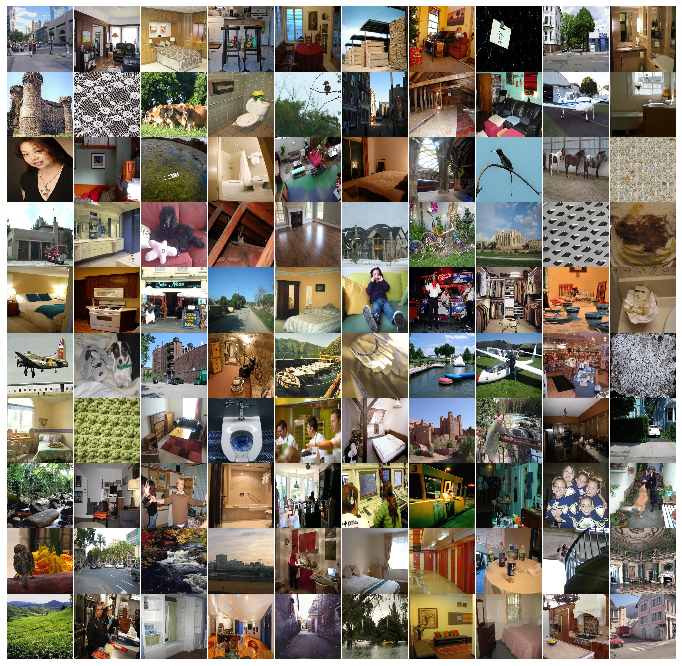

In [105]:
hayfield.view_counter_images()